In [177]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [178]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5   ZBTB8B  \
Patient_ID                                            ...                     
55_control    1.000000  0.363133  0.374212  0.611161  ...      0.0  0.71077   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...      0.0  0.00000   
72_control    0.648401  0.134017  0.200420  0.679453  ...      0.0  0.00000   
120_control   0.579519  0.248934  0.759250  0.755407  ...      0.0  0.00000   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...      0.0  0.00000   
...                ...       ...       ...       ...  ...      ...      ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...      0.0  0.00000   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...      0.0  0.00000   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...      0.0  0.00000   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...      0.0  0.00000   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...      0.0  0.00000   

              EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  C6orf106  \
Patient_ID                                                                     
55_control          0.0       0.564155      0.0  0.410548      0.0  0.466889   
168_CD_plain        0.0       0.619646      0.0  0.576526      0.0  0.247033   
72_control          0.0       0.978062      0.0  0.322280      0.0  0.809681   
120_control         0.0       0.630496      0.0  0.633583      0.0  0.568599   
258_CD_plain        0.0       0.575404      0.0  0.754246      0.0  0.349619   
...                 ...            ...      ...       ...      ...       ...   
15_CD_plain         0.0       0.424522      0.0  0.647019      0.0  0.358576   
182_CD_plain        0.0       0.643529      0.0  0.676222      0.0  0.534238   
164_CD_plain        0.0       0.592646      0.0  0.784037      0.0  0.401977   
53_CD_plain         0.0       0.503764      0.0  0.726674      0.0  0.482674   
97_CD_plain         0.0       0.480415      0.0  0.702185      0.0  0.809611   

              RPL7AP54     LCE2A  
Patient_ID                        
55_control         0.0  1.000000  
168_CD_plain       0.0  0.008198  
72_control         0.0  0.618383  
120_control        0.0  0.208173  
258_CD_plain       0.0  0.000000  
...                ...       ...  
15_CD_plain        0.0  0.000000  
182_CD_plain       0.0  0.646805  
164_CD_plain       0.0  0.232271  
53_CD_plain        0.0  0.000000  
97_CD_plain        0.0  0.461059  

[182 rows x 220 columns]

In [179]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...      0.0   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...      0.0   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...      0.0   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...      0.0   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...      0.0   
...                     ...       ...       ...       ...  ...      ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...      0.0   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...      0.0   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...      0.0   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...      0.0   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
253_CD_plain          0.0        0.0       0.790435      0.0  0.849076   
105_CD_plain          0.0        0.0       0.917793      0.0  0.604771   
2_CD_plain            0.0        0.0       0.063827      0.0  0.703353   
184_CD_plain          0.0        0.0       0.650608      0.0  0.749070   
312_CD_plain          0.0        0.0       0.481745      0.0  0.717561   
...                   ...        ...            ...      ...       ...   
107_CD_plain          0.0        0.0       0.486418      0.0  0.625206   
279_CD_plain          0.0        0.0       0.217050      0.0  0.889784   
179_CD_plain          0.0        0.0       0.492356      0.0  0.744538   
70_CD_deep_ulcer      0.0        0.0       0.518714      0.0  0.461913   
256_CD_deep_ulcer     0.0        0.0       0.591308      0.0  0.713509   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
253_CD_plain           0.0  0.686223       0.0  0.395101  
105_CD_plain           0.0  0.668052       0.0  0.671177  
2_CD_plain             0.0  0.826523       0.0  0.000000  
184_CD_plain           0.0  0.548091       0.0  0.134641  
312_CD_plain           0.0  0.541235       0.0  0.000000  
...                    ...       ...       ...       ...  
107_CD_plain           0.0  0.722622       0.0  0.000000  
279_CD_plain           0.0  0.514313       0.0  0.000000  
179_CD_plain           0.0  0.494143       0.0  0.165054  
70_CD_deep_ulcer       0.0  0.528017       0.0  0.000000  
256_CD_deep_ulcer      0.0  0.587452       0.0  0.000000  

[78 rows x 220 columns]

In [180]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [181]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [182]:
full_ds = pd.concat([x_train_scaled, x_test_scaled], axis=0)
full_ds

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
55_control         0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain       0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control         0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control        0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain       0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
55_control         1.000000  0.363133  0.374212  0.611161  ...      0.0   
168_CD_plain       0.311962  0.251356  0.553554  0.441131  ...      0.0   
72_control         0.648401  0.134017  0.200420  0.679453  ...      0.0   
120_control        0.579519  0.248934  0.759250  0.755407  ...      0.0   
258_CD_plain       0.370517  0.244987  0.445387  0.798000  ...      0.0   
...                     ...       ...       ...       ...  ...      ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...      0.0   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...      0.0   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...      0.0   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...      0.0   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...      0.0   

                    ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                                
55_control         0.71077        0.0       0.564155      0.0  0.410548   
168_CD_plain       0.00000        0.0       0.619646      0.0  0.576526   
72_control         0.00000        0.0       0.978062      0.0  0.322280   
120_control        0.00000        0.0       0.630496      0.0  0.633583   
258_CD_plain       0.00000        0.0       0.575404      0.0  0.754246   
...                    ...        ...            ...      ...       ...   
107_CD_plain       0.00000        0.0       0.486418      0.0  0.625206   
279_CD_plain       0.00000        0.0       0.217050      0.0  0.889784   
179_CD_plain       0.00000        0.0       0.492356      0.0  0.744538   
70_CD_deep_ulcer   0.00000        0.0       0.518714      0.0  0.461913   
256_CD_deep_ulcer  0.00000        0.0       0.591308      0.0  0.713509   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
55_control             0.0  0.466889       0.0  1.000000  
168_CD_plain           0.0  0.247033       0.0  0.008198  
72_control             0.0  0.809681       0.0  0.618383  
120_control            0.0  0.568599       0.0  0.208173  
258_CD_plain           0.0  0.349619       0.0  0.000000  
...                    ...       ...       ...       ...  
107_CD_plain           0.0  0.722622       0.0  0.000000  
279_CD_plain           0.0  0.514313       0.0  0.000000  
179_CD_plain           0.0  0.494143       0.0  0.165054  
70_CD_deep_ulcer       0.0  0.528017       0.0  0.000000  
256_CD_deep_ulcer      0.0  0.587452       0.0  0.000000  

[260 rows x 220 columns]

In [7]:
# compound_model = keras.models.load_model('../data/models/cd_encoder')

OSError: No file or directory found at ../data/models/cd_encoder

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               97240     
                                                                 
 batch_normalization (BatchN  (None, 440)              1760      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 440)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               97020     
                                                                 
 batch_normalization_1 (Batc  (None, 220)              880       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 220)               0

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [400]:
idx = 41

In [401]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [402]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [403]:

with open("../data/models/shap/ind_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [404]:
# shap_values[0][0].shape

In [405]:
shap_values = shap_values[0]

In [406]:
# shap_values[0] *= 100000

In [407]:
shap_values

[array([[  0.        ,  10.97447298,  21.15028555, -11.40005442,
         -16.07852996,   0.        ,   0.        , -28.96762431,
           9.01118062,  55.25255629,   0.        ,  -2.30025908,
           0.        ,   0.        , -28.44654644,   0.        ,
          22.79709746,   5.45714472,  55.93995763,  -2.36545136,
          -0.84423057,  15.49066651,   0.13711062,   0.        ,
           6.03122536,   0.        , -28.67023298,   0.        ,
         -20.01304766, -25.33158384,   0.        ,   0.        ,
         -18.59963195,   0.        ,   0.        ,   0.        ,
          20.42223063,  -5.19084903,  -7.42798011, -21.85199968,
           7.63235272, -27.93517261,   0.        ,  39.40745141,
           3.18602261, -28.46925502,   0.        ,   0.        ,
         -23.65232272,  13.70234303,   0.        ,   0.        ,
           7.91523091,   0.        , -25.51618481, -17.86209353,
           0.        , -29.51532638,  11.86689466, -28.59296914,
           0.        ,   

In [408]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [409]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
260_CD_deep_ulcer     0.0        0.0       0.652111      0.0  0.876483   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
260_CD_deep_ulcer      0.0  0.551273       0.0  0.262322  

[1 rows x 220 columns]

In [410]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.61531537e-28 6.99893629e-02 9.30010637e-01]
Predicted class: 2


#### Control

In [411]:
import shap

In [412]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [413]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [414]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [415]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

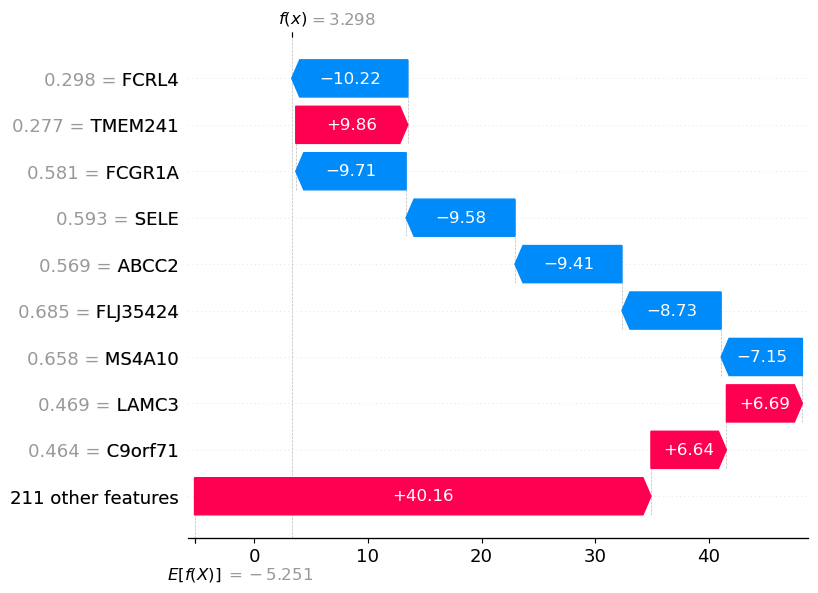

In [416]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [417]:
idx = 41

In [418]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [419]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [420]:

with open("../data/models/shap/fd_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [421]:
# shap_values[0][0].shape

In [422]:
shap_values = shap_values[0]

In [423]:
# shap_values[0] *= 100000

In [424]:
shap_values

[array([[  3.81247901,   0.        ,   5.1709716 , -10.01331699,
         -19.20061852,   0.        ,   0.        , -27.78780931,
           5.74667957,  38.35131619,   0.        ,   0.        ,
           0.        ,   0.        , -27.89322686,   0.        ,
          28.89171226,   5.78025445,  53.68339922,   0.17427355,
          -3.37355593,  31.23905479,  -1.16146242,   0.        ,
           0.        ,   0.        , -28.2807355 ,   0.        ,
         -28.92064699, -22.0519493 ,   0.        ,   0.        ,
         -27.1828557 ,   0.        ,   0.        ,   0.        ,
          36.22793892, -14.51993674, -15.24433378, -27.26260573,
          16.95706084, -26.30865611,  -2.65070262,  28.79717024,
           6.47274177, -28.61606099,   0.        ,   0.        ,
         -26.8401342 ,  26.33149329,   0.        ,   0.        ,
          15.40967082,   0.        , -28.90531252,  -6.47696377,
           0.        , -33.6177087 ,  43.49407377, -27.59281817,
           0.        ,   

In [425]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [426]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
260_CD_deep_ulcer     0.0        0.0       0.652111      0.0  0.876483   

                   IGLV2_5  C6orf106  RPL7AP54     LCE2A  
Patient_ID                                                
260_CD_deep_ulcer      0.0  0.551273       0.0  0.262322  

[1 rows x 220 columns]

In [427]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.61531537e-28 6.99893629e-02 9.30010637e-01]
Predicted class: 2


#### Control

In [428]:
import shap

In [429]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [430]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [431]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [432]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

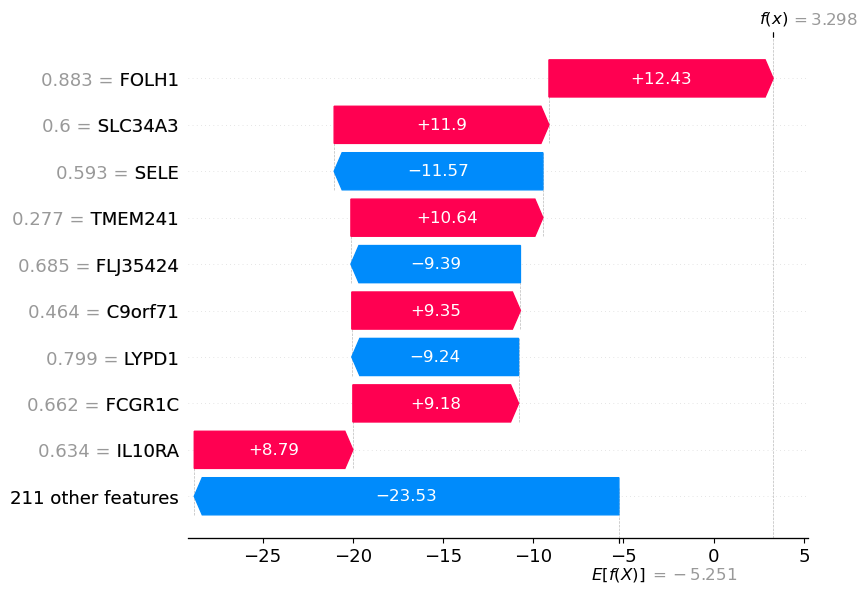

In [433]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [290]:
full_ds = np.concatenate([x_train_scaled, x_test_scaled], axis=0)
full_ds.shape

(260, 220)

## Dependent - 18

In [491]:
idx = 18

In [492]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [493]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [502]:

with open("../data/models/shap/new_fd_18_250_1", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [503]:
# shap_values[0][0].shape

In [504]:
shap_values = shap_values[0]

In [498]:
# shap_values[0] *= 100000

In [499]:
for i in range(len(shap_values)):
    
    shap_values[i][np.isnan(shap_values[i])] = 0

In [505]:
shap_values

[array([[ 0.00000000e+00, -2.18018857e+01, -1.16698469e+01,
          0.00000000e+00, -5.40465664e+00,  0.00000000e+00,
          1.54733562e+00,  0.00000000e+00,  4.29479838e+01,
         -5.94304497e+00,  0.00000000e+00, -1.48990095e+01,
          2.17672401e+00,  0.00000000e+00,  2.02633793e+00,
          1.26081227e+01, -3.27038408e+01, -1.38386939e+01,
         -1.25758280e+01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -2.17605869e+01,
         -1.97764899e+00,  5.34603692e+01,  0.00000000e+00,
          1.69243294e+01,  2.54413100e+01,  2.23249319e+01,
          0.00000000e+00,  0.00000000e+00,  6.54396209e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -1.36827814e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  6.63196786e+00,
          3.69103437e+01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -2.24805293e+01,  0.00000000e+00,
         -2.14462724e+01,  2.45360584e+0

In [506]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [507]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [508]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.71991469e-53 1.81023097e-03 9.98189769e-01]
Predicted class: 2


#### Control

In [509]:
import shap

In [510]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [511]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [512]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [513]:
# deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

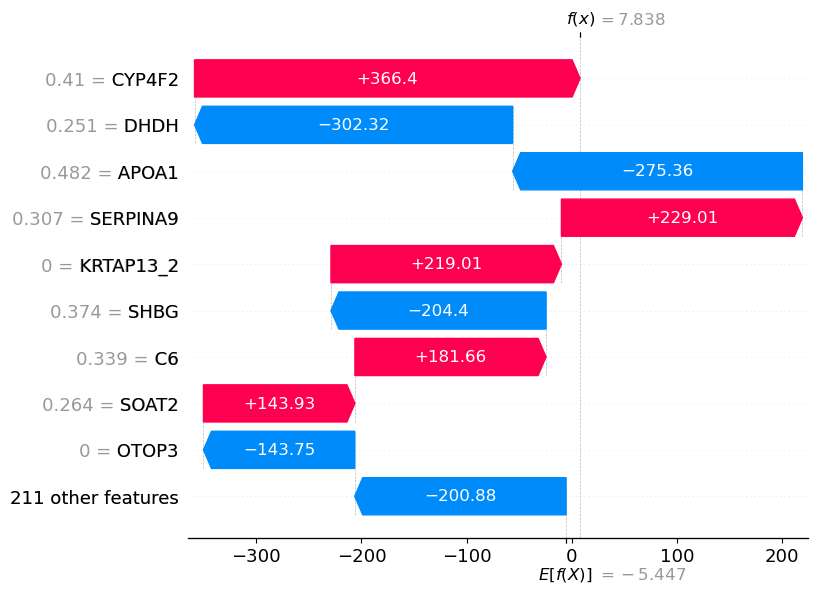

In [514]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [452]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


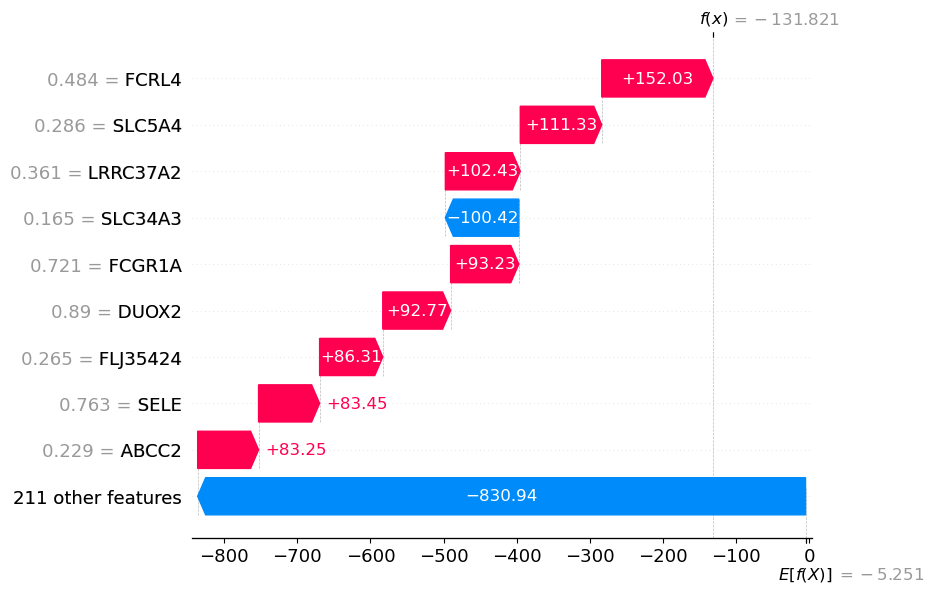

In [453]:
shap.waterfall_plot(explanation)

## Independent - 18

In [454]:
idx = 18

In [455]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


In [456]:


with open("../data/models/shap/ind_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [457]:
shap_values = shap_values[0]

In [458]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [459]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...      0.0   

                  ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                              
46_CD_deep_ulcer     0.0        0.0       0.360556      0.0  0.748095   

                  IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                            
46_CD_deep_ulcer      0.0  0.675387       0.0    0.0  

[1 rows x 220 columns]

In [460]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1.25423451e-58 5.76809775e-07 9.99999423e-01]
Predicted class: 2


#### Control

In [461]:
import shap

In [462]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [463]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [464]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [465]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
#deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

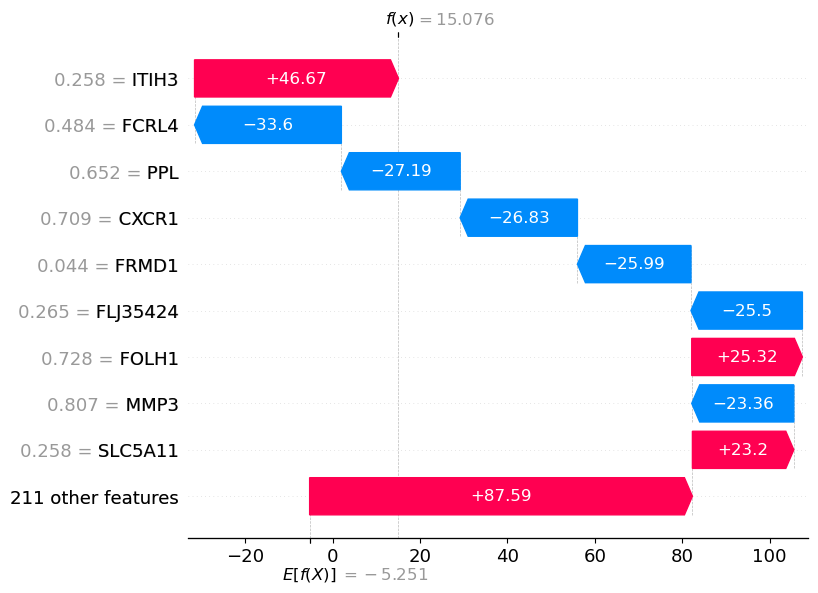

In [466]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [467]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


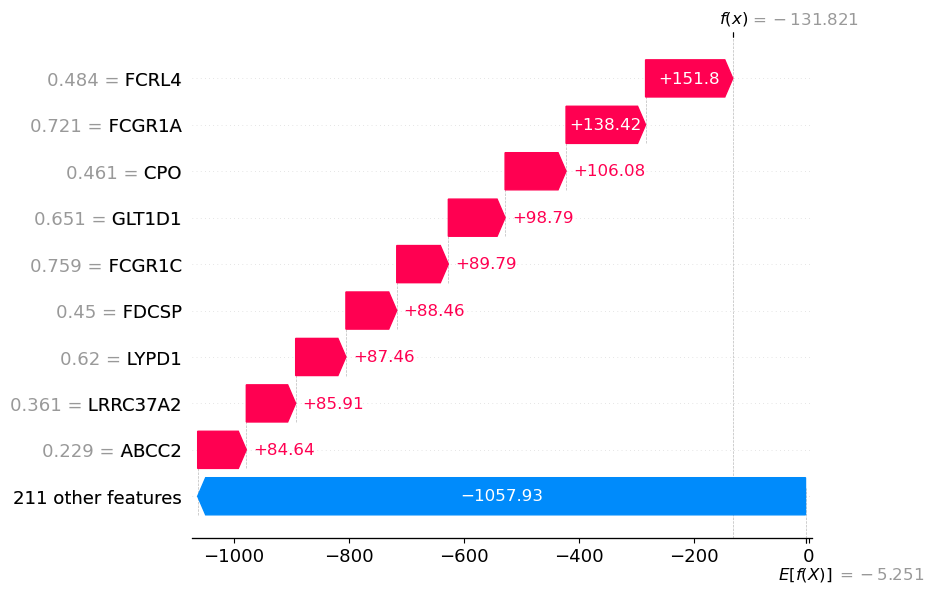

In [468]:
shap.waterfall_plot(explanation)

## Independent - 77

In [338]:
idx = 77

In [339]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [340]:


with open("../data/models/shap/ind_train_77_1", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [341]:
shap_values = shap_values[0]

In [342]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [343]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...  C1QTNF5  ZBTB8B  \
Patient_ID                                           ...                    
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...      0.0     0.0   

                   EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  IGLV2_5  \
Patient_ID                                                                
256_CD_deep_ulcer        0.0       0.591308      0.0  0.713509      0.0   

                   C6orf106  RPL7AP54  LCE2A  
Patient_ID                                    
256_CD_deep_ulcer  0.587452       0.0    0.0  

[1 rows x 220 columns]

In [344]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [4.44751545e-20 3.72501413e-01 6.27498587e-01]
Predicted class: 2


#### Control

In [345]:
import shap

In [346]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [347]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [348]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [349]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

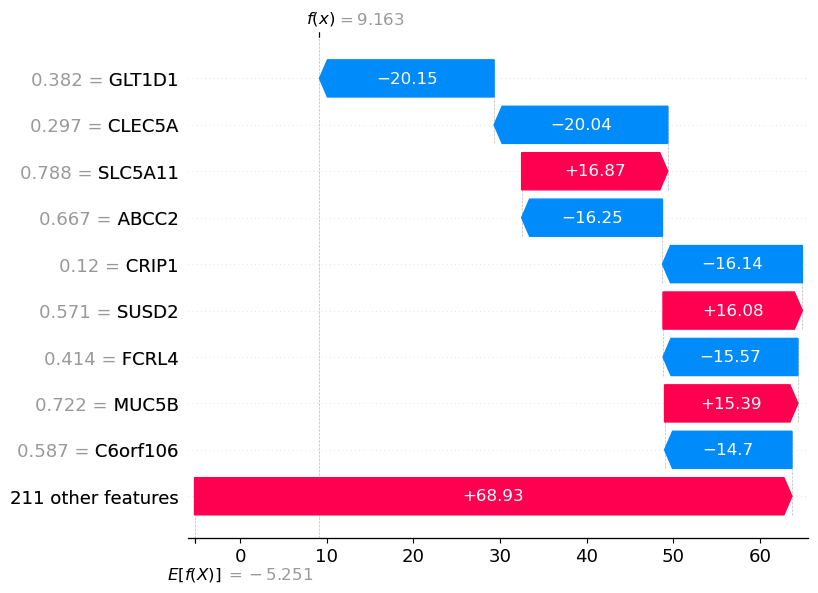

In [350]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 77

In [474]:
idx = 77

In [475]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


In [476]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [477]:

with open("../data/models/shap/new_fd_77_250_1", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [478]:
# shap_values[0][0].shape

In [479]:
shap_values = shap_values[0]

In [480]:
# shap_values[0] *= 100000

In [481]:
shap_values

[array([[ 1.08914215, -3.77424492,  0.        ,  4.33109161, -1.99376704,
          0.        ,  0.47273322,  1.92999251, 12.83396628, -1.68268234,
          0.        , -3.94264342, -0.72279241,  2.15891856,  4.54352061,
          0.        ,  0.        , -1.27237129, -0.83122968,  0.        ,
          0.        ,  0.71617773,  0.07939969, -1.17181198, -2.10326461,
          3.50994299,  0.        ,  4.98032212,  9.53280145,  5.69598217,
          0.        ,  0.        ,  0.        ,  0.        , -3.33801633,
         -0.22716758,  0.        ,  0.        , -1.23547947, -5.97573795,
          0.        ,  3.30463035,  3.69787826,  0.        ,  0.        ,
          0.26420376, -4.07466605,  0.99983886, -3.74537654,  0.43467769,
          0.        ,  0.        ,  1.15564525,  0.        ,  7.89330301,
          0.        ,  0.        ,  2.52397357,  0.        ,  9.15549611,
         -3.674167  , -4.55626498, -3.41867649, -2.3363947 ,  5.75283083,
         -2.24282841, -1.17559181,  0.

In [482]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [483]:
idx = 77
patient = x_train_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4   APOB     APOC3      AQP9  \
Patient_ID                                                                   
163_CD_deep_ulcer  0.549471  0.535225  0.541534  0.613  0.501887  0.539542   

                         C6   CEACAM7    CHI3L1    ABCC2  ...  C1QTNF5  \
Patient_ID                                                ...            
163_CD_deep_ulcer  0.121304  0.469165  0.749159  0.50967  ...      0.0   

                   ZBTB8B  EEF1A1P16  SLX1A_SULT1A3  SF3A3P1   ZNRF2P1  \
Patient_ID                                                               
163_CD_deep_ulcer     0.0        0.0       0.572396      0.0  0.718266   

                   IGLV2_5  C6orf106  RPL7AP54  LCE2A  
Patient_ID                                             
163_CD_deep_ulcer      0.0  0.425646       0.0    0.0  

[1 rows x 220 columns]

In [484]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [6.94370546e-14 9.61754095e-03 9.90382459e-01]
Predicted class: 2


#### Control

In [485]:
import shap

In [486]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [487]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [488]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [489]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

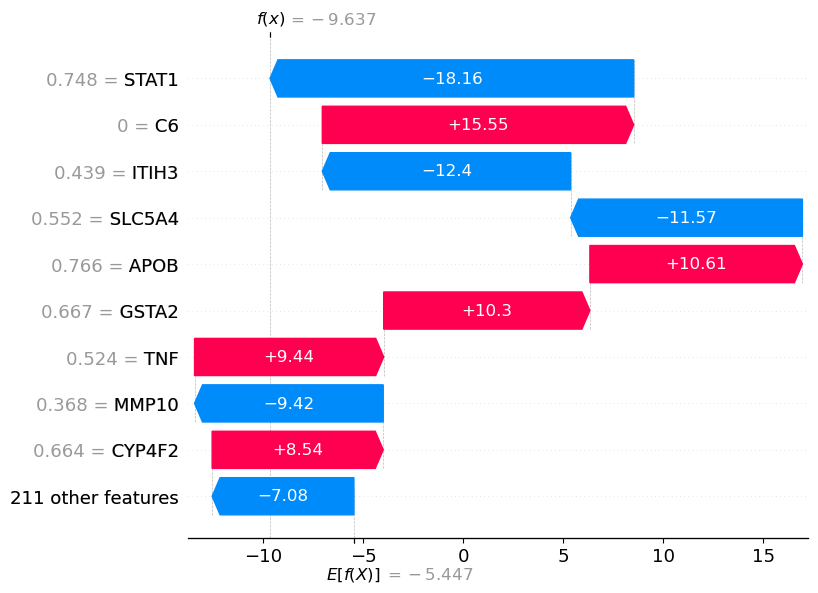

In [490]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))